In [114]:
#Importar as bibliotecas necessárias

import pandas as pd
print("Pandas version: ", pd.__version__)

import numpy as np
print("Numpy version: ", np.__version__)

import graphviz
print("Graphviz version: ", graphviz.__version__)

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

Pandas version:  1.3.2
Numpy version:  1.21.1
Graphviz version:  0.17


In [115]:
# Importar o dataset de filmes
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [116]:
# Importar o dataset de avaliações
ratings = pd.read_csv('ratings.csv', usecols = ['userId', 'movieId','rating'])
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n') 
ratings.head()

Shape of ratings dataset is:  (25000095, 3) 

Max values in dataset are 
 userId     162541.0
movieId    209171.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     0.5
dtype: float64 



,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [117]:
print('O dataset contém ', len(ratings), ' avaliações de ', len(movies), ' filmes.')

O dataset contém  25000095  avaliações de  62423  filmes.


In [118]:
# Função para obter o gênero e suas avaliações 
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

# Calcular a média das avaliações
genre_ratings = get_genre_ratings(ratings, movies, ['Action', 'Drama'], ['avg_action_rating', 'avg_drama_rating'])
print(genre_ratings.shape)
genre_ratings.head()

(162540, 2)


,avg_action_rating,avg_drama_rating
1,4.12,3.87
2,3.70,3.57
3,3.64,3.89
4,3.19,3.74
5,3.72,3.82


In [119]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_action_rating'] < score_limit_1) & (genre_ratings['avg_drama_rating'] > score_limit_2)) | ((genre_ratings['avg_drama_rating'] < score_limit_1) & (genre_ratings['avg_action_rating'] > score_limit_2))]
    
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    
    # Converte o DataFrame para uma NumPy matriz de registro
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset


biased_dataset = bias_genre_rating_dataset(genre_ratings, 3, 2.5)


print( "Number of records: ", len(biased_dataset))
print(biased_dataset.shape)
biased_dataset.head()

Number of records:  302
(302, 3)


,index,avg_action_rating,avg_drama_rating
0,31,2.27,2.53
1,74,2.90,2.78
2,79,1.25,4.22
3,80,2.62,2.64
4,81,1.83,2.92


In [120]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

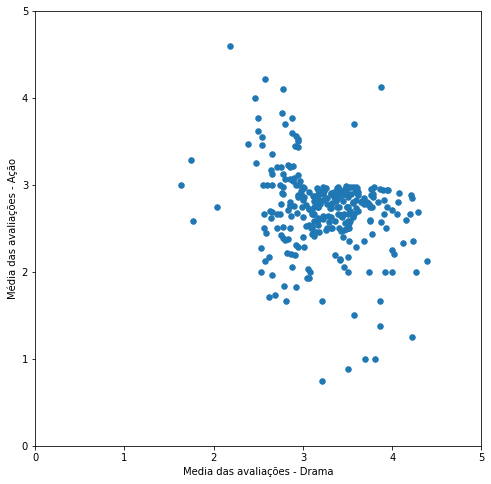

In [121]:
draw_scatterplot(biased_dataset['avg_drama_rating'],'Media das avaliações - Drama', biased_dataset['avg_action_rating'], 'Média das avaliações - Ação')

In [122]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Media das avaliações - Drama')
    ax.set_ylabel('Média das avaliações - Ação')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_drama_rating'], clustered['avg_action_rating'], c=clustered['group'], s=20, cmap=cmap)

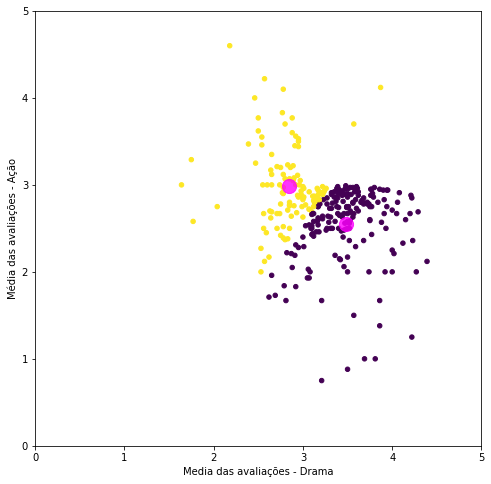

In [123]:
X = biased_dataset[['avg_drama_rating','avg_action_rating']].values

kmeans_1 = KMeans(n_clusters=2)
predictions_1 = kmeans_1.fit_predict(X)
draw_clusters(biased_dataset, predictions_1)
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=200, alpha=0.8);

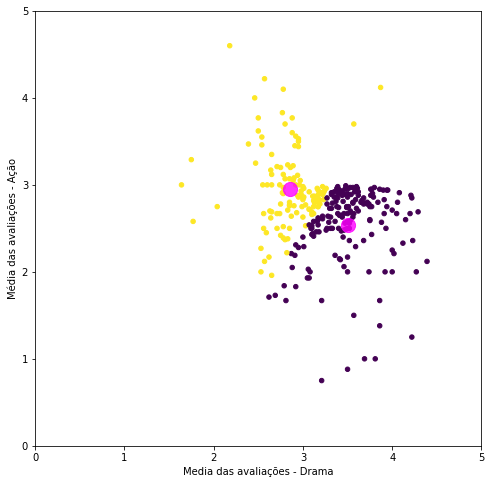

In [125]:
kmeans_1_1 = KMeans(n_clusters=2,algorithm = "elkan")
predictions_1_1 = kmeans_1_1.fit_predict(X)
draw_clusters(biased_dataset, predictions_1_1)
centers = kmeans_1_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=200, alpha=0.8);

In [154]:
print("1. Algorithm = Auto \nClusters = 2")
print("Inertia =", kmeans_1.inertia_)
print("N_iter =", kmeans_1.n_iter_)
print("\n")

print("2. Algorithm = Elkan \nClusters = 2")
print("Inertia =", kmeans_1_1.inertia_)
print("N_iter =", kmeans_1_1.n_iter_)
print("\n")

1. Algorithm = Auto 
Clusters = 2
Inertia = 89.85490502899601
N_iter = 16


2. Algorithm = Elkan 
Clusters = 2
Inertia = 89.85490502899601
N_iter = 8




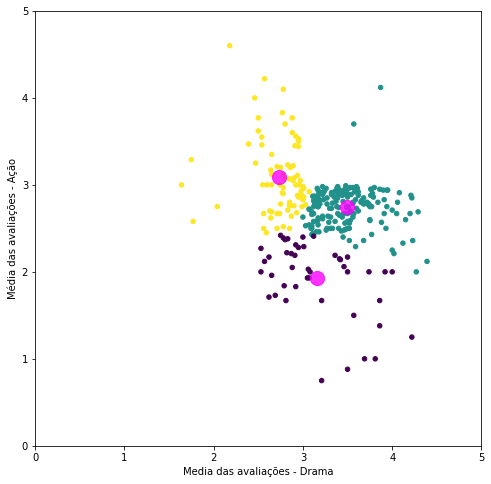

In [127]:
kmeans_2 = KMeans(n_clusters=3)
predictions_2 = kmeans_2.fit_predict(X)
draw_clusters(biased_dataset, predictions_2)
centers = kmeans_2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=200, alpha=0.8);

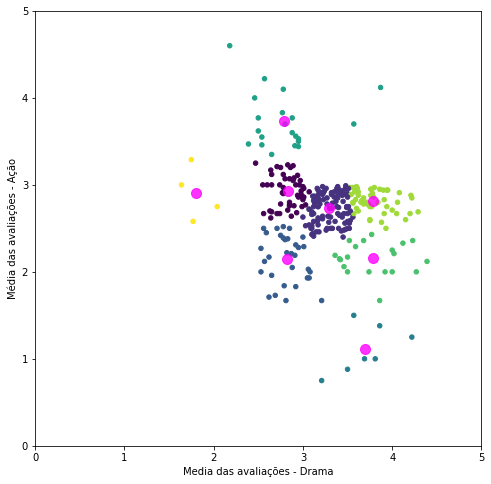

In [128]:
kmeans_3 = KMeans(n_clusters=8)
predictions_3 = kmeans_3.fit_predict(X)
draw_clusters(biased_dataset, predictions_3)
centers = kmeans_3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100, alpha=0.8);

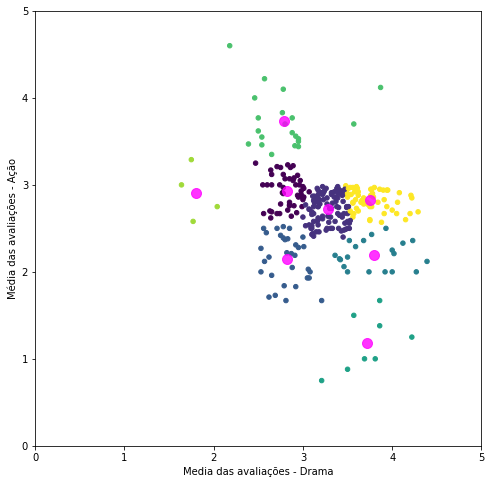

In [129]:
kmeans_3_1 = KMeans(n_clusters=8, algorithm = "elkan")
predictions_3_1 = kmeans_3_1.fit_predict(X)
draw_clusters(biased_dataset, predictions_3_1)
centers = kmeans_3_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100, alpha=0.8);

In [152]:
print("1. Algorithm = Auto \nClusters = 8")
print("Inertia =", kmeans_3.inertia_)
print("N_iter =", kmeans_3.n_iter_)
print("\n")

print("2. Algorithm = Elkan \nClusters = 8")
print("Inertia =", kmeans_3_1.inertia_)
print("N_iter =", kmeans_3_1.n_iter_)
print("\n")

1. Algorithm = Auto 
Clusters = 8
Inertia = 23.44095599424529
N_iter = 15


2. Algorithm = Elkan 
Clusters = 8
Inertia = 23.394248220981474
N_iter = 10




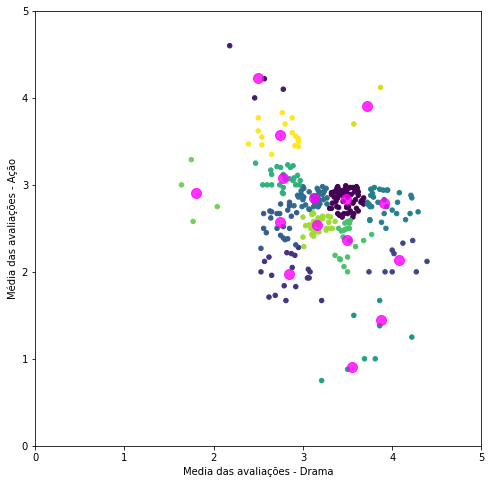

In [131]:
kmeans_4 = KMeans(n_clusters=15)
predictions_4 = kmeans_4.fit_predict(X)
draw_clusters(biased_dataset, predictions_4)
centers = kmeans_4.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='magenta', s=100, alpha=0.8);

In [132]:
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    fig = plt.figure(figsize=(8,8))
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
    for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    ax.set_xlabel('Media das avaliações - Drama')
    ax.set_ylabel('Média das avaliações - Ação')

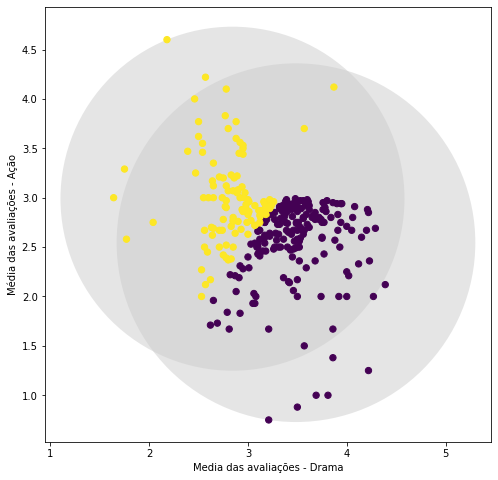

In [133]:
plot_kmeans(kmeans_1, X)

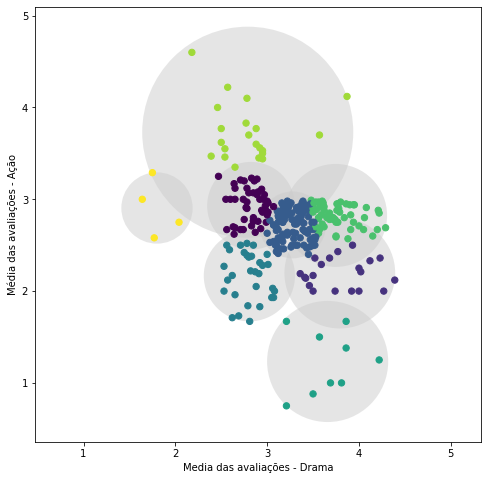

In [134]:
plot_kmeans(kmeans_3, X)

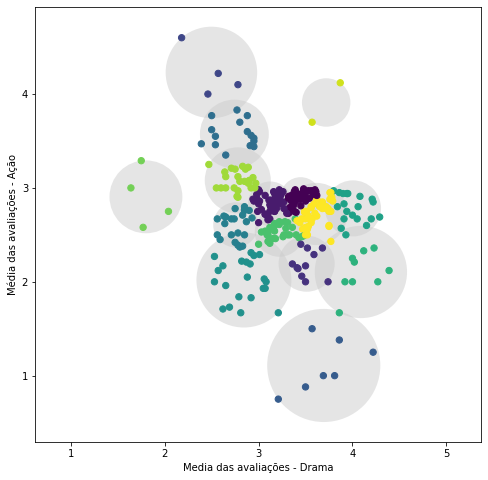

In [135]:
plot_kmeans(kmeans_4, X)

In [151]:
print("Clusters = 2")
print(kmeans_1.inertia_)
print(kmeans_1.n_iter_)
print("\n")

print("Clusters = 3")
print(kmeans_2.inertia_)
print(kmeans_2.n_iter_)
print("\n")

print("Clusters = 8")
print(kmeans_3.inertia_)
print(kmeans_3.n_iter_)
print("\n")

print("Clusters = 15")
print(kmeans_4.inertia_)
print(kmeans_4.n_iter_)
print("\n")

Clusters = 2
89.85490502899601
16


Clusters = 3
63.150991315952844
11


Clusters = 8
23.44095599424529
15


Clusters = 15
10.803655614975876
9




In [137]:
kmeans_1.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [138]:
 class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(X)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Método do cotovelo - (Elbow Method Graph)')
        plt.subplot(121).set_xlabel('Número de clusters')
        plt.subplot(121).set_ylabel('Soma dos quadrados da distância')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Diferenças entre 2 grupos (clusters) consecutivos')
        plt.subplot(122).set_xlabel('Número de clusters')
        plt.subplot(122).set_ylabel('Diferença do quadrado da distância')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

In [139]:
elbow_method = elbowMethod(X)

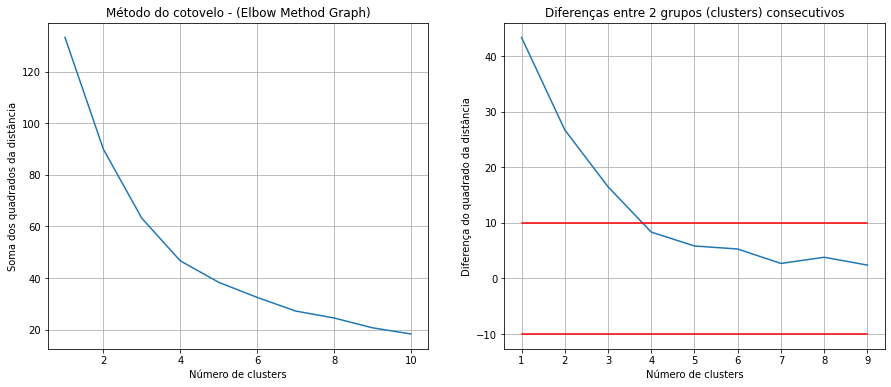

In [140]:
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)

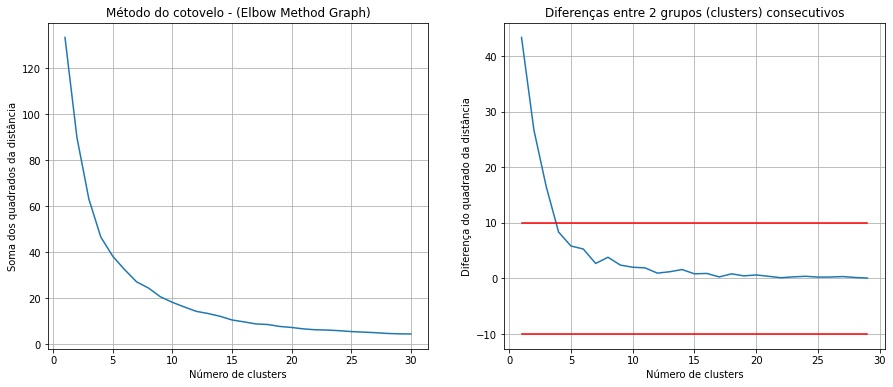

In [141]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 10)

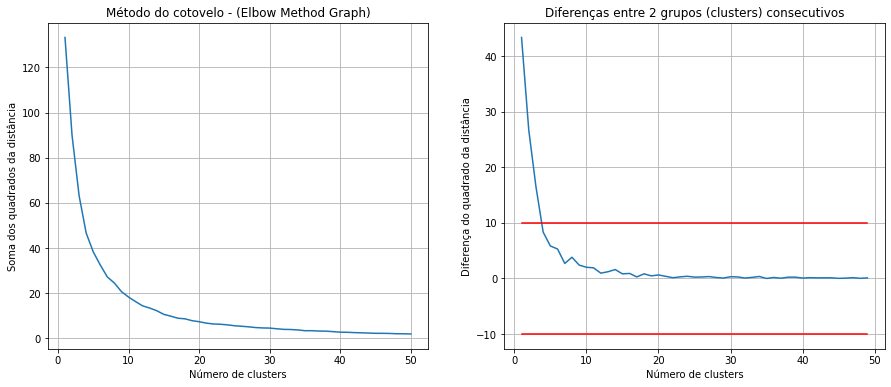

In [142]:
elbow_method.run(31, 50)
elbow_method.showPlot(boundary = 10)

In [143]:
distance = kmeans_1.fit_transform(X)
distance

array([[0.76244173, 1.01721209],
       [0.09876478, 0.81292591],
       [2.18214336, 1.47457067],
       [0.40282026, 0.87350849],
       [1.12857802, 0.92504187],
       [0.71936103, 0.42340142],
       [1.08948773, 0.59297877],
       [1.22026093, 0.6781992 ],
       [0.31879759, 0.47916735],
       [0.28306154, 0.50175109],
       [0.77203416, 0.10082356],
       [0.3425963 , 0.48088775],
       [0.74033207, 0.29848907],
       [0.6657203 , 0.19859958],
       [0.89938221, 0.47811803],
       [0.62211629, 0.25772818],
       [0.45714009, 0.66141761],
       [0.2087512 , 0.79632385],
       [0.12912721, 0.81312077],
       [0.7686024 , 0.69589099],
       [0.99937947, 0.53720165],
       [0.17234052, 0.80443518],
       [0.52985357, 0.45375487],
       [0.26633649, 1.03600204],
       [0.7470747 , 0.7212296 ],
       [0.73366268, 0.14080506],
       [0.14123749, 0.67203966],
       [0.57400654, 0.41295754],
       [0.58125945, 0.37420057],
       [0.57990931, 1.13533502],
       [0.

In [144]:
frame = pd.DataFrame(X)
frame['cluster'] = predictions_1
frame['cluster'].value_counts()

0    188
1    114
Name: cluster, dtype: int64

In [147]:
frame['cluster'] = predictions_4
frame['cluster'].value_counts()

0     64
5     43
6     33
12    32
4     24
9     24
10    21
2     19
14    15
3      9
7      4
11     4
1      4
8      4
13     2
Name: cluster, dtype: int64

In [148]:
frame['cluster'] = predictions_3
frame['cluster'].value_counts()

1    114
6     54
0     50
2     32
4     21
5     20
3      7
7      4
Name: cluster, dtype: int64

In [149]:
frame['cluster'] = predictions_3_1
frame['cluster'].value_counts()

1    107
7     61
0     49
2     32
5     21
3     20
4      8
6      4
Name: cluster, dtype: int64